In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
gamma = 42.58  # MHz/T, gyromagnetic ratio for hydrogen
B0 = 3  # T, magnetic field strength
T2 = 0.1  # s, T2 relaxation time (chosen arbitrarily)


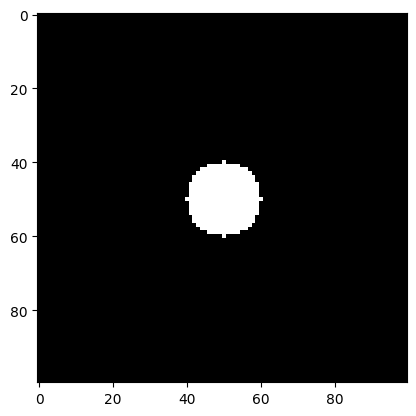

In [3]:
# Create circle phantom
size = 100  # Size of the phantom in pixels
phantom = np.zeros((size, size))

y, x = np.ogrid[-size/2:size/2, -size/2:size/2]
mask = x*x + y*y <= 10*10
phantom[mask] = 1

# Plot the phantom
plt.imshow(phantom, cmap='gray')
plt.show()

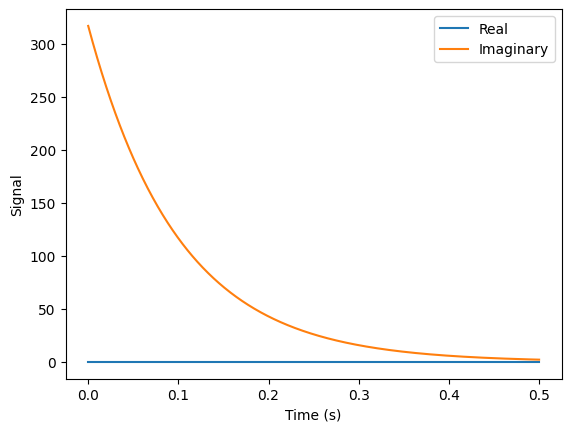

In [5]:
# Simulate spins
spins = phantom * np.exp(1j * 0)  # All spins start along z-axis

# Apply RF pulse
spins *= np.exp(1j * np.pi/2)  # 90-degree pulse

# Simulate signal acquisition
times = np.linspace(0, 5*T2, 1000)  # Times at which to sample the signal
signal = np.zeros_like(times, dtype=complex)

for i, t in enumerate(times):
    signal[i] = np.sum(spins * np.exp(-t/T2))  # Signal is sum of all spins

# Plot signal
plt.figure()
plt.plot(times, signal.real, label='Real')
plt.plot(times, signal.imag, label='Imaginary')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.legend()
plt.show()
